Saving 19_img_.png to 19_img_.png
Image uploaded: 19_img_.png
Entropy Values: [np.float64(7.812149785033208), np.float64(6.227269519694159), np.float64(1.0670028001419505)]
Fuzzy Densities: [0.51714097 0.41222663 0.0706324 ]
Lambda value: 2.1282899714083023e-08
Measure (0,): 0.5171409702973336
Measure (1,): 0.41222663291573836
Measure (2,): 0.07063239678692805
Measure (0, 1): 0.9293676077501453
Measure (0, 2): 0.5877733678616601
Measure (1, 2): 0.48285903032235117
Measure (0, 1, 2): 1.0000000003204643
Sorted Indices: [0 1 2]
Sorted Entropies: [np.float64(7.812149785033208), np.float64(6.227269519694159), np.float64(1.0670028001419505)]
Sorted Measures: [np.float64(0.5171409702973336), np.float64(0.9293676077501453), np.float64(1.0000000003204643)]
Weight for subset (np.int64(0),): 0.5171409702973336
Weight for subset (np.int64(0), np.int64(1)): 0.41222663745281163
Weight for subset (np.int64(0), np.int64(1), np.int64(2)): 0.07063239257031906


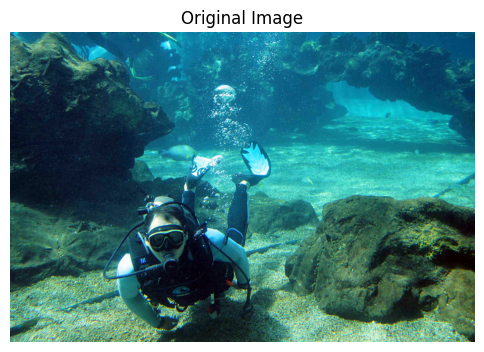

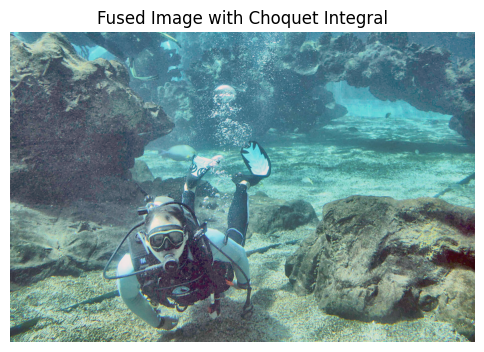

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
from google.colab import files
from scipy.optimize import fsolve
from itertools import combinations

# Upload the image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print(f"Image uploaded: {image_path}")

# Load image
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Error: Image {image_path} not found or could not be loaded.")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply CLAHE
def apply_clahe(image):
    ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    y_channel, cr, cb = cv2.split(ycrcb)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    y_channel_clahe = clahe.apply(y_channel)
    enhanced_image = cv2.merge((y_channel_clahe, cr, cb))
    return cv2.cvtColor(enhanced_image, cv2.COLOR_YCrCb2RGB)

# Apply Multi-Scale Retinex (MSR)
def retinex_msr(image, sigma_list=[15, 80, 250]):
    image = image.astype(np.float32) + 1e-3
    retinex = np.zeros_like(image, dtype=np.float32)
    for sigma in sigma_list:
        blur = cv2.GaussianBlur(image, (0, 0), sigma)
        retinex += np.log1p(image) - np.log1p(blur)
    retinex = cv2.normalize(retinex, None, 0, 255, cv2.NORM_MINMAX)
    return np.uint8(retinex)

# Dehazing function
def dehaze(image):
    image_float = image.astype(np.float32) / 255.0
    atmospheric_light = np.max(image_float, axis=(0, 1))
    transmission = np.ones(image_float.shape[:2]) * 0.7
    transmission = np.stack([transmission] * 3, axis=-1)
    image_dehazed = np.clip((image_float - atmospheric_light) / (1 - transmission) + atmospheric_light, 0, 1)
    return np.uint8(image_dehazed * 255)

# Compute entropy
def compute_entropy(image):
    hist, _ = np.histogram(image.flatten(), bins=256, range=(0, 256))
    hist = hist / np.sum(hist)
    entropy = -np.sum(hist * np.log2(hist + 1e-7))
    return entropy

# Compute fuzzy measure using dynamically computed lambda
def solve_lambda_dynamic(fuzzy_densities):
    def equation(lamb):
        return np.prod([1 + lamb * g for g in fuzzy_densities]) - (1 + lamb)

    # Dynamic initial guess based on fuzzy densities
    initial_guess = 1.0 / np.sum(fuzzy_densities) if np.sum(fuzzy_densities) > 0 else 0.1

    lamb_solution = fsolve(equation, initial_guess)[0]

    # Ensure lambda is within reasonable bounds
    if np.isnan(lamb_solution) or np.abs(lamb_solution) > 10:
        lamb_solution = 0.01  # Fallback value

    if np.isclose(lamb_solution, 0):
        lamb_solution = 0.01  # Avoid zero lambda

    return lamb_solution

# Compute fuzzy measures
def compute_fuzzy_measures(entropies):
    fuzzy_densities = np.array(entropies) / np.sum(entropies)
    lamb = solve_lambda_dynamic(fuzzy_densities)
    n = len(fuzzy_densities)
    measures = {}

    print("Fuzzy Densities:", fuzzy_densities)
    print("Lambda value:", lamb)

    for r in range(1, n + 1):
        for subset in combinations(range(n), r):
            subset_tuple = tuple(subset)
            if len(subset_tuple) == 1:
                measures[subset_tuple] = fuzzy_densities[subset_tuple[0]]
            else:
                measures[subset_tuple] = sum(measures[(i,)] for i in subset_tuple) + \
                                         lamb * np.prod([measures[(i,)] for i in subset_tuple])
            print(f"Measure {subset_tuple}: {measures[subset_tuple]}")

    return measures

# Compute Choquet Integral
def choquet_integral(images, entropies):
    measures = compute_fuzzy_measures(entropies)
    sorted_indices = np.argsort(entropies)[::-1]
    sorted_images = [images[i] for i in sorted_indices]
    sorted_measures = [measures[tuple(sorted_indices[:i+1])] for i in range(len(sorted_indices))]

    print("Sorted Indices:", sorted_indices)
    print("Sorted Entropies:", [entropies[i] for i in sorted_indices])
    print("Sorted Measures:", sorted_measures)

    fusion_result = np.zeros_like(images[0], dtype=np.float32)
    for i in range(len(sorted_images)):
        weight = sorted_measures[i] - (sorted_measures[i-1] if i > 0 else 0)
        print(f"Weight for subset {tuple(sorted_indices[:i+1])}: {weight}")
        fusion_result += weight * sorted_images[i].astype(np.float32)
    return np.uint8(np.clip(fusion_result, 0, 255))

# Apply enhancement methods
clahe_result = apply_clahe(image_rgb)
retinex_result = retinex_msr(image_rgb)
dehazed_result = dehaze(image_rgb)

# Compute entropy values
entropy_values = [compute_entropy(clahe_result), compute_entropy(retinex_result), compute_entropy(dehazed_result)]
print("Entropy Values:", entropy_values)

# Perform fusion using Choquet Integral
fused_result = choquet_integral([clahe_result, retinex_result, dehazed_result], entropy_values)

# Display results
def show_image(title, img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

show_image("Original Image", image_rgb)
show_image("Fused Image with Choquet Integral", fused_result)

#using average initial guesses based on fuzzy density values